elliptic_txs_classes.csv
elliptic_txs_edgelist.csv
elliptic_txs_features.csv


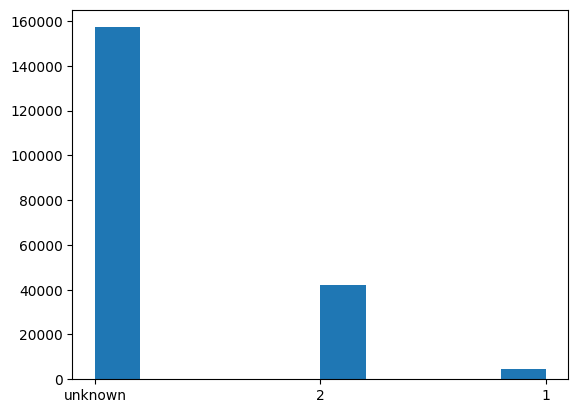

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [2]:
import torch
import torch_geometric
import torch_scatter
import torch_sparse
import pandas as pd

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

PATH='bitcoin_dataset'

!ls bitcoin_dataset

classes_file = PATH + '/elliptic_txs_classes.csv'
edge_file    = PATH + '/elliptic_txs_edgelist.csv'
feature_file = PATH + '/elliptic_txs_features.csv'

data_classes=pd.read_csv(classes_file)
data_classes.head(5)

data_classes['class'].unique()
# 1 - licit
# 2 - illicit

# data_classes.head(5000)['class']

from matplotlib import pyplot as plt
plt.hist(data_classes['class'])
plt.show()

num_nodes=len(data_classes)
num_nodes

data_classes['class']=data_classes['class'].map({'unknown':2,'1':1,'2':0})
data_classes.head(5)

data_edges=pd.read_csv(edge_file)
data_edges.head(5)
# edges between two nodes

data_features=pd.read_csv(feature_file,header=None)
data_features.head(5)
# 166-dim feature for each node

# merging class data and features data
data_classes_and_features=data_features.merge(data_classes,how='left',right_on="txId",left_on=0)
data_classes_and_features = data_classes_and_features.sort_values(0).reset_index(drop=True)
data_classes_and_features.head()

# The Node IDs or the transaction IDs are too large , so not feasible. We will map them to indices
# data_classes_and_features.head(200)

data_classes_and_features[0].values

nodes=data_classes_and_features[0].values
mapped_node_IDs={}
for i,j in enumerate(nodes):
    mapped_node_IDs[j]=i



mapped_node_IDs[230425980]

# we need to do this mapping for the rest of the data
data_edges['txId1']=data_edges['txId1'].map(mapped_node_IDs)
data_edges['txId2']=data_edges['txId2'].map(mapped_node_IDs)

data_edges['txId1']

data_edges.head(10)

data_edges=data_edges.astype(int)

data_edges.head(5)

# converting the edges data to tensor
edge_indices=data_edges.values
edge_indices=torch.tensor(edge_indices,dtype=torch.long).contiguous()
edge_indices

data_classes.head(5)

node_features=data_classes_and_features.drop(['txId'],axis=1)
# liccit_classified_index=data_classes_an.loc[data_classes_and_features['class']==0]
# liccit_classified_index
# node_features.drop(columns=[0,1,'class'])
# node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)

# node_features_tensor.shape

llicit_classified_index=node_features.loc[node_features['class']==0].index
illicit_classified_index=node_features.loc[node_features['class']==1].index
unknown_classified_index=node_features.loc[node_features['class']==2].index
classified_index=node_features.loc[node_features['class']!=2].index

import numpy as np
node_features=node_features.drop(columns=[0,1,'class'])
node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)

node_features.shape

llicit_classified_index

illicit_classified_index

unknown_classified_index

#converting node features to tensor
# import numpy as np
# node_features_tensor=torch.tensor(np.array(node_features.values,dtype=np.double),dtype=torch.double)
# node_features_tensor

labels=data_classes_and_features['class'].values

labels

classified_index.values

from sklearn.model_selection import train_test_split
train_index,val_index=train_test_split(classified_index.values,test_size=0.2)
train_index

# initializing all edge weights(attention) to 1
weights = torch.tensor([1]* data_edges.shape[1] , dtype=torch.double) 

data_edges_tensor=torch.tensor(np.array(data_edges.values).T , dtype=torch.long).contiguous()

from torch_geometric.data import Data
data=Data(x=node_features_tensor,edge_index=data_edges_tensor,edge_attr=weights,y=torch.tensor(labels,dtype=torch.double))

data.train_index=train_index
data.val_index=val_index
data.test_index=unknown_classified_index

data_edges.loc[data_edges['txId1']==1]
# data_edges

config={
    "heads":2,
    "model":"GAT2",
    "learning_rate":0.01,
    "dropout":0.3,
    "hidden_dim":128,
    "epochs":100
}

from torch_geometric.nn import GATConv,GATv2Conv , GCNConv
import torch.nn as nn
import torch.nn.functional as func

config

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, config):
        super(GAT_Model, self).__init__()
        self.config = config
        
        # GAT convolution layers
        self.conv1 = GATConv(in_channels=input_dim, out_channels=hidden_dim, heads=config["heads"])
        self.conv2 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        self.conv3 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        
        # Linear, dropout, and activation layers
        self.aggregation = nn.Sequential(
            nn.Linear(in_features=hidden_dim * config['heads'], out_features=hidden_dim),
            nn.Dropout(p=config["dropout"]),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = self.aggregation(x)
        x = torch.sigmoid(x)
        
        return x


from torch.optim import Adam
from torch.nn import BCELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau


# node_features=166
model=GAT_Model(input_dim=data.num_node_features,hidden_dim=config['hidden_dim'],output_dim=1,config=config)
model.parameters
# optimizer=Adam()

type(data.edge_index)

data.edge_index.shape

data.x.shape

optimizer=Adam(params=model.parameters(),lr=config['learning_rate'])
scheduler=ReduceLROnPlateau(optimizer=optimizer,mode='min')
loss=BCELoss()

class GAT_Trainer:
    def __init__(self,model):
        self.model=model
    def train(self,data,optimizer,scheduler,loss,config):
        self.data=data
        epochs=config['epochs']
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            predictions=self.model(self.data)
            print(predictions)
            break
        

trainer=GAT_Trainer(model=model)
trainer.train(data=data,optimizer=optimizer,scheduler=scheduler,loss=loss,config=config)

In [127]:
train_data.x.shape[1]

168

In [160]:
# class GAT_Model(nn.Module):
#     def __init__(self,input_dim,hidden_dim,output_dim,config):
#         super(GAT_Model,self).__init__()
#         self.config=config
#         # GAT convolution layers
#         self.conv1=GATConv(in_channels=input_dim,out_channels=hidden_dim,heads=config["heads"])
#         self.conv2=GATConv(in_channels=config['heads']*hidden_dim,out_channels=hidden_dim,heads=config['heads'])
#         self.conv3=GATConv(in_channels=config['heads']*hidden_dim,out_channels=hidden_dim,heads=config['heads'])
        
#         # Now we will add the linear, dropout and activation layers
#         self.aggregation=nn.Sequential(
#             nn.Linear(in_features=hidden_dim*config['heads'],out_features=hidden_dim),
#             nn.Dropout(p=config["dropout"]),
#             nn.Linear(in_features=hidden_dim,out_features=output_dim)
#         )
        
#     def forward(self,data):
#         x,edge_index=data.x,data.edge_index
#         x=self.conv1(x,edge_index)
#         x=func.dropout(nn.ReLU(x),p=self.config['heads'])
#         x=self.conv2(x,edge_index)
#         x=func.dropout(nn.ReLU(x),p=self.config['heads'])
#         x=self.conv3(x,edge_index)
#         x=self.aggregation(x)
#         x=func.sigmoid(x)
#         return x
        